## Proba-V NDVI Analysis

In [0]:
%matplotlib inline

In [0]:
!pip install IPython
!pip install pandas
!pip install pylab
!pip install seaborn

In [0]:
from IPython.display import Image
!pip install earthengine-api
import ee, datetime
import pandas as pd
from pylab import *
import seaborn as sns
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose


ee.Authenticate()

ee.Initialize()

     |████████████████████████████████| 153kB 2.8MB/s 
  Created wheel for earthengine-api: filename=earthengine_api-0.1.204-cp36-none-any.whl size=175146 sha256=0c9b3a8f1b24853a9c7a29d01ed139832fce20e538f58a63a6a30547399b465c
  Stored in directory: /root/.cache/pip/wheels/1c/84/12/072bd182af991b0f0b9c1599de80fa7b15179ba427106c5b17
Successfully built earthengine-api
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verificat

### Set Proba Vegetation dates, initialize collection
Selected Location of point is from the Proba-V Footprint X18Y02 in Odder,Denmark. (The geographical center of Denmark, minus Bornholm)

In [0]:
# Set start and end date
startTime = datetime.datetime(2017, 7, 1)
endTime = datetime.datetime(2019, 10, 1)

# Create image collection
collection = ee.ImageCollection('VITO/PROBAV/C1/S1_TOC_100M').filterDate(startTime, endTime).select('RED', 'NIR')


# # Create image collection
collection_s = ee.ImageCollection('COPERNICUS/S2_SR').filterDate(startTime, endTime).select('B4', 'B8')


# Create point in Odder, Denmark (Proba-V Footprint: X18Y02 eller hvad er det?)
point = {'type':'Point', 'coordinates':[10.151320, 55.981851]};

In [0]:
ee.Image(collection)
ee.Image(collection_s)

### Retrieve information, reshape and calculate NDVI
Retrieving information from point geometry with a buffer of 200km over image collection. Reshaping data and calculating NDVI from **RED** and **NIR** band.

In [0]:
info = collection.getRegion(point,200000).getInfo()
info_s = collection_s.getRegion(point,200000).getInfo()

###PROBA V

In [0]:
# Reshape image collection 
header = info[0]
data = array(info[1:])

iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

# List of used image bands
band_list = ['RED',u'NIR']


iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)

# Calculate NDVI
red = yData[:,0]
nir = yData[:,1]
ndvi = (nir - red) / (nir + red)

###SENTINEL II

In [0]:
# Reshape image collection 
header_s = info_s[0]
data_s = array(info_s[1:])

iTime_s = header_s.index('time')
time_s = [datetime.datetime.fromtimestamp(i/1000) for i in (data_s[0:,iTime_s].astype(int))]

# List of used image bands
band_list_s = ['B4',u'B8']


iBands_s = [header_s.index(b) for b in band_list_s]
yData_s = data_s[0:,iBands_s].astype(np.float)

# Calculate NDVI
red_s = yData_s[:,0]
nir_s = yData_s[:,1]
ndvi_s = (nir_s - red_s) / (nir_s + red_s)

### Reshape NDVI array into Pandas Dataframe 

In [0]:
#Proba V
df = pd.DataFrame(data=ndvi, index=list(range(len(ndvi))), columns=['NDVI'])
df = df.interpolate()
df['Date'] = pd.Series(time, index=df.index)
df = df.set_index(df.Date)
df.index = pd.to_datetime(df.index)
df['NDVI']=df['NDVI'].fillna(0)

In [0]:
#Sentinel II
df_s = pd.DataFrame(data=ndvi_s, index=list(range(len(ndvi_s))), columns=['NDVI_s'])
df_s = df_s.interpolate()
df_s['Date'] = pd.Series(time_s, index=df_s.index)
df_s = df_s.set_index(df_s.Date)
df_s.index = pd.to_datetime(df_s.index)
df_s['NDVI_s']=df_s['NDVI_s'].fillna(0)

### Obtain statistical information over all elements of the Time-Series

In [0]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2477 entries, 2017-07-02 10:42:52 to 2019-09-30 10:44:58.066000
Data columns (total 2 columns):
NDVI_s    2477 non-null float64
Date      2477 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 58.1 KB


### Visualize Proba-V NDVI Time Series

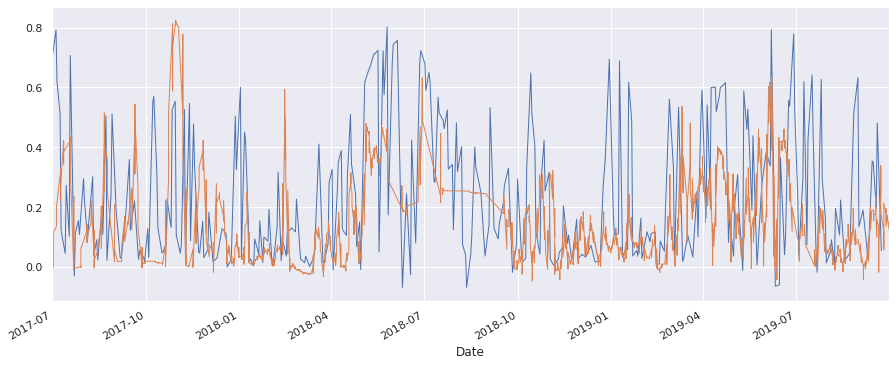

In [0]:
sns.set(rc={'figure.figsize':(15, 6)})
df['NDVI'].plot(linewidth=1);
df_s['NDVI_s'].plot(linewidth=1);

### Seasonal Decomposition

Text(0.5, 1.0, 'NDVI trendlines for PROBA V and Sentinel II')

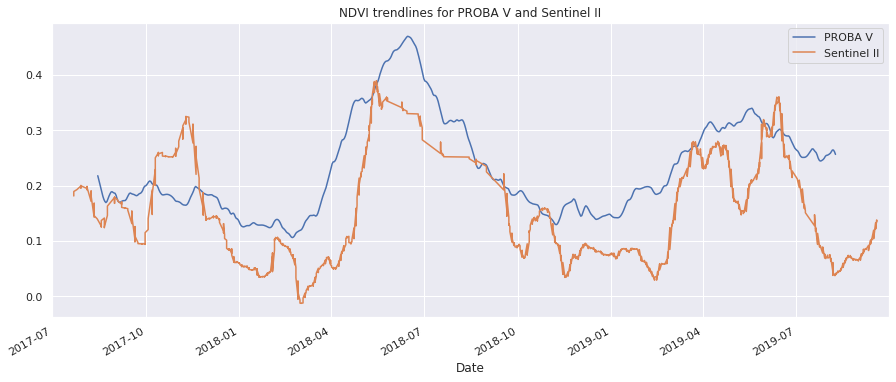

In [0]:
sd=seasonal_decompose(df['NDVI'], model='additive', freq=90)
sd_s=seasonal_decompose(df_s['NDVI_s'], model='additive', freq=90)


# FREQ= i SD er et tal for hvor mange dage bagud der skal laves en trend udfra. 
# Dette bruges i dens moving average function; jo flere dage (højere tal), desto mere udlignet bliver den.
# Man får lidt forskellige trendlinjer hvis man ændre på den. 
# Læs evt. afsnittet om moving averages for en bedre forklaring.
# Penis 8==D

#nemt #flotpenis #hashtag


#sd.seasonal.plot()
sd.trend.plot()
sd_s.trend.plot()
#sd_s.observed.plot()
#sd.resid.plot()
plt.legend(['PROBA V', 'Sentinel II'])
plt.title('NDVI trendlines for PROBA V and Sentinel II')

Text(0.5, 1.0, 'Observed NDVI values for PROBA V and Sentinel II satellites respectively')

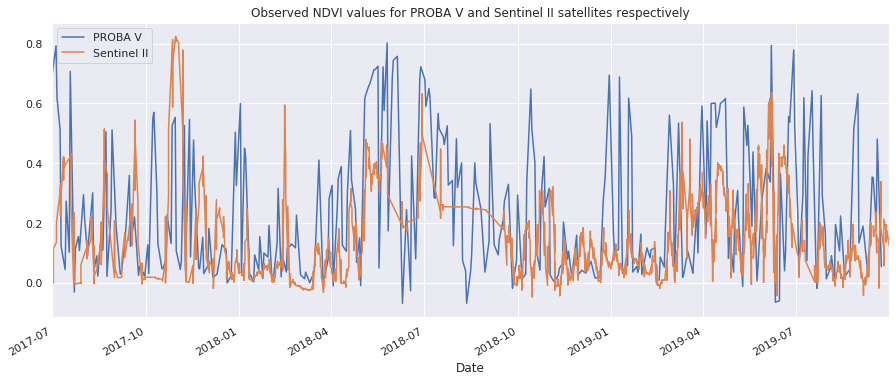

In [0]:

sd.observed.plot()
sd_s.observed.plot()

# sd.trend.plot()
# sd_s.trend.plot()
# #sd_s.observed.plot()
#sd.resid.plot()
plt.legend(['PROBA V', 'Sentinel II'])
plt.title('Observed NDVI values for PROBA V and Sentinel II satellites respectively')

### Resample data
Resampling to weekly level and calculate the percentage change over one year.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, '52 Weeks Percentage Change')

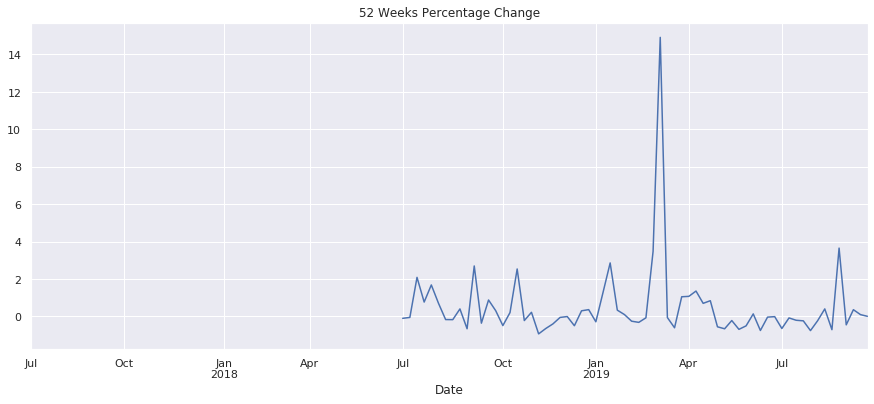

In [0]:
df_monthly=df.resample('W', 'mean')
df_monthly['pct_change'] = df_monthly.pct_change(52)
df_monthly['pct_change']['2015':].plot()
plt.title('52 Weeks Percentage Change')

In [0]:
%matplotlib inline

In [0]:
from IPython.display import Image
import ee
ee.Initialize()

In [0]:
probav = collection
probav_s = collection_s



# Reduce image collection to mean
probav_mean = probav.mean()
probav_mean_s = probav_s.mean()


# Set location to Europe (Proba-V Footprint: X18Y02) 
point = ee.Geometry.Point(10.151320, 55.981851)
luxembourg = point.buffer(200000).bounds().getInfo()['coordinates']

In [0]:
ndvi = probav_mean.normalizedDifference(["NIR", "RED"])
Image(url=ndvi.getThumbUrl({
    'region':luxembourg,
    'min':-0.5,
    'max':0.5,
    'palette':['ffffe5','f7fcb9','d9f0a3','addd8e','78c679','41ab5d','238443','006837','004529']
}))

In [0]:
#sentinel 2

ndvi_s = probav_mean_s.normalizedDifference(["B4", "B8"])
Image(url=ndvi.getThumbUrl({
    'region':luxembourg,
    'min':-0.5,
    'max':0.5,
    'palette':['blue', 'white', 'green']
}))

In [0]:
Image(url=probav_mean.getThumbUrl({
    'region':luxembourg,
    'min':0,
    'max':255,
    'bands':['NDVI'],
    'palette':['ffffe5','f7fcb9','d9f0a3','addd8e','78c679','41ab5d','238443','006837','004529']
}))